In [1]:
import numpy as np
import scipy.stats as stats
from scipy.signal import peak_widths, find_peaks
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import itertools


In [164]:
class DynaToy:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.layers = [np.zeros([m, 1]) for m in self.layer_sizes]

        self.r = np.concatenate(self.layers)
        self.W = np.zeros([len(self.r), len(self.r)])

        self.in_idx = np.arange(0, layer_sizes[0])
        self.out_idx = np.arange(len(self.r) - layer_sizes[-1], len(self.r))
        self.vth = np.zeros_like(self.r)

        self.W_ff_0 = 0.03
        self.W_ff_1 = 0.03
        self.W_fb_0 = 0.03
        self.W_fb_1 = 0.03

        self.W_r_0 = 0.03
        self.W_r_1 = 0.03

        self.dt = 1
        self.tau = 10   

    
    def init_weights(self, kappas = [], plot = False, return_matrices = False, recurrence = False):
        W = np.zeros_like(self.W)
        W_L = []

        
        if not kappas:
            self.kappas = [1 for i in range(len(self.layer_sizes))]
        else:
            self.kappas = kappas

        # FF and FB connection weights
        for i in range(len(self.layer_sizes) - 1):
            rstart = int(np.sum(self.layer_sizes[:(i+1)]))
            rstop = rstart + self.layer_sizes[i+1]

            cstart = int(np.sum(self.layer_sizes[:i]))
            cstop = cstart + self.layer_sizes[i]

            shape = (self.layer_sizes[i+1], self.layer_sizes[i])

            W_l = np.zeros(shape)
            x = np.linspace(0, 2*np.pi, shape[1])

            for ii in range(shape[0]):
                loc = ((ii/shape[0]) * 2*np.pi)
                rf = stats.vonmises.pdf(x, self.kappas[i], loc)
                # rf /= np.linalg.norm(rf)
                W_l[ii, :] = rf

            
            W_L.append(W_l)
            
            # FF Weights
            W[rstart:rstop, cstart:cstop] = W_l  * self.W_ff_0 + self.W_ff_1
            # FB weights
            W[cstart:cstop, rstart:rstop] = W_l.T  * self.W_fb_0 + self.W_fb_1

        if recurrence == 'vonmises':
            start = 0
            k1, k2, s1, s2 = 10, 1, 1, 1
            for i in range(len(self.layer_sizes)):
                stop = int(np.sum(self.layer_sizes[:(i+1)]))
                
                shape = [self.layer_sizes[i], self.layer_sizes[i]]
                W_l = np.zeros(shape)
                x = np.linspace(0, 2*np.pi, shape[1])

                for ii in range(shape[0]):
                    loc = ((ii/shape[0]) * 2*np.pi)
                    rf = stats.vonmises.pdf(x, k1, loc, scale = s1) - stats.vonmises.pdf(x, k2, loc, scale = s2) 
                    rf /= np.linalg.norm(rf)
                    W_l[ii, :] = rf * 1

                W[start:stop, start:stop] = W_l
                W_L.append(W_l)

                start = int(np.sum(self.layer_sizes[:(i+1)]))

        if recurrence == 'cosine':
            start = 0
            for i in range(len(self.layer_sizes)):
                stop = int(np.sum(self.layer_sizes[:(i+1)]))

                W_l = self.cos_weights(layer = i, W_0 = self.W_r_0, W_1 = self.W_r_1)

                W[start:stop, start:stop] = W_l
                W_L.append(W_l)

                start = int(np.sum(self.layer_sizes[:(i+1)]))


        if plot:
            plt.imshow(W)
            plt.title("Model Weights")

        if return_matrices:
            return W, W_L


        W /= np.linalg.norm(W)
        return W
    

    def step(self, r):    
        self.r = self.W @ r
        self.r /= np.linalg.norm(self.r)
        # self.r /= self.r.max()
        
        return self.r
    

    def euler(self, h):
        r = np.zeros_like(h)
        y = self.W @ self.r + h - self.vth
        y[y < 0] = 0

        r[:] = (1 - (self.dt/self.tau)) * self.r + (self.dt/self.tau) * y
        
        return r
    

    def W_theta(self, theta, W_0, W_1):
        return W_1 + 2*W_0 * np.cos(theta)


    def cos_weights(self, layer, W_0 = 0.3, W_1 = 1.5):
        delta = 2*np.pi/self.layer_sizes[0]
        grid_positions = np.arange(0, self.layer_sizes[layer])

        theta = np.linspace(0, 2*np.pi, self.layer_sizes[layer])

        W = np.zeros([theta.size, theta.size])

        # Set weights
        for i, j, in itertools.product(grid_positions, grid_positions):
            W[i, j] = self.W_theta(theta[i] - theta[j],  W_0, W_1) * (delta / (2*np.pi))

        return W
    

    def reset(self):
        self.layers = [np.zeros([m, 1]) for m in self.layer_sizes]

        self.r = np.concatenate(self.layers)


    def plot(self, timecourse, h, stim_on = 0):
        # Plotting
        fig, axs = plt.subplots(2, 2, figsize = [18, 12])

        # Timecourse
        ax = axs[0, 0]
        fig1 = ax.imshow(timecourse, aspect = 'auto', interpolation='none', cmap = 'RdBu_r')
        cbar = fig.colorbar(fig1)
        cbar.minorticks_on()
        ax.set_title("Response Timecourse")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Nodes")
        pos = 0
        for i, layer in enumerate(self.layer_sizes):
            ax.text(0, 1-(pos/self.r.shape[0]), "Layer %d" % i, horizontalalignment='left',
                        verticalalignment='top', transform=ax.transAxes, color = 'white')
            pos += layer
            if i != len(self.layer_sizes)-1:
                ax.axhline(pos, color = 'black')
            
            
        # Amplitude
        ax = axs[0, 1]
        start = 0
        for i in range(len(self.layer_sizes)):
            if i+1:
                midpoint = int(start + self.layer_sizes[i]/2)
                timeseries = timecourse[midpoint, :]
                ax.plot(timeseries, label = 'Layer %d' % i)
            start += self.layer_sizes[i]

        ax.hlines(h.max(), xmin = 0, xmax = timecourse.shape[1], color = 'gray', linestyle = "--", label = 'Input Amplitude')
        if stim_on:
            ax.axvline(self, ymin = 0, ymax = 1, color = 'red', label = 'Stim Offset', alpha = 0.5)
        ax.legend()
        ax.set_title("Response Amplitude")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Amplitude at Center (Arbitrary Units)")

        # Compute widths in each layer, plot over time
        ax = axs[1, 0]

        start = 0
        Widths = np.zeros([len(self.layer_sizes), timecourse.shape[1]])

        for i, layer in enumerate(self.layer_sizes):
            stop = start + layer
            layer_timecourse = timecourse[start:stop, :]

            for t, response in enumerate(layer_timecourse.T):
                
                peak, _ = find_peaks(response)
                width, _, _, _ = peak_widths(response, peak)
                if len(width) != 1:
                    width = 0
                Widths[i, t] = (width/layer) * 360
            start += self.layer_sizes[i]
            ax.plot(Widths[i, :], label = 'Layer %d' % i)

        h_peak, _ = find_peaks(h.squeeze())
        h_width, _, _, _ = peak_widths(h.squeeze(), h_peak)
        h_width = h_width/h.shape[0] * 360

        ax.hlines(h_width, xmin = 0, xmax = timecourse.shape[1], color = 'gray', linestyle = "--", label = 'Input Width')
        if stim_on:
            ax.axvline(stim_on, ymin = 0, ymax = 1, color = 'red', alpha = 0.5, label = 'Stim Offset')
        ax.legend()
        ax.set_title("FWHM")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Width (in deg)")

        ax = axs[1, 1]
        eigvals = np.linalg.eigvals(self.W)
        # extract real part 
        x = [ele.real for ele in eigvals] 
        # extract imaginary part 
        y = [ele.imag for ele in eigvals]
        ax.scatter(x, y)
        circ = plt.Circle((0, 0), radius=1, edgecolor='b', facecolor='None')
        circ2 = plt.Circle((0, 0), radius=0.5, edgecolor='b', facecolor='None')
        circ3 = plt.Circle((0, 0), radius=1.5, edgecolor='b', facecolor='None')
        ax.add_patch(circ)
        ax.add_patch(circ2)
        ax.add_patch(circ3)
        ax.set_title("Eigenvalues")
        ax.set_xlabel("Real")
        ax.set_ylabel("Imag")

        plt.show()
            
        
        




# Main Model Parameters
- layer sizes: # of nodes in each 'layer'
- kappas: kappa parameters for the Von Mises functions that map connections from one layer's nodes to the next
- W_ff_0: Scalar that scales the FF weights 
- W_ff_1: Constant that shifts the FF weights. 
- W_fb_0: Scalar that scales the FB weights 
- W_fb_1: Constant that shifts the FB weights 

Recurrence and lateral connections are optional. 
- recurrence: String that declares what type of recurrence to use. Default is '' (none). Cosine works. Von Mises Explodes. 
- W_r_0: Scalar that scales the Recurrence weights
- W_r_1: Constant that shifts the Recurrence weights


# Simulation Parameters
- n_timesteps: # of timepoints
- x_pos: center of VonMises used to simulate the stimulus input signal
- stim_on: duration of stimulus input signal
- k_input: kappa parameter of the Von Mises used for the input signal


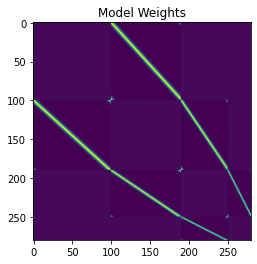

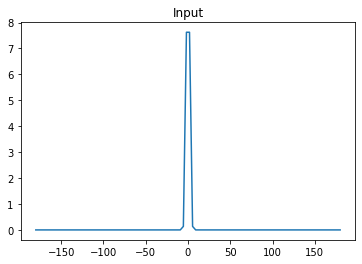

/var/folders/86/mx5k0dps5gb_vlv7mwrrymd00000gn/T/ipykernel_1579/3830467131.py:158: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(fig1)


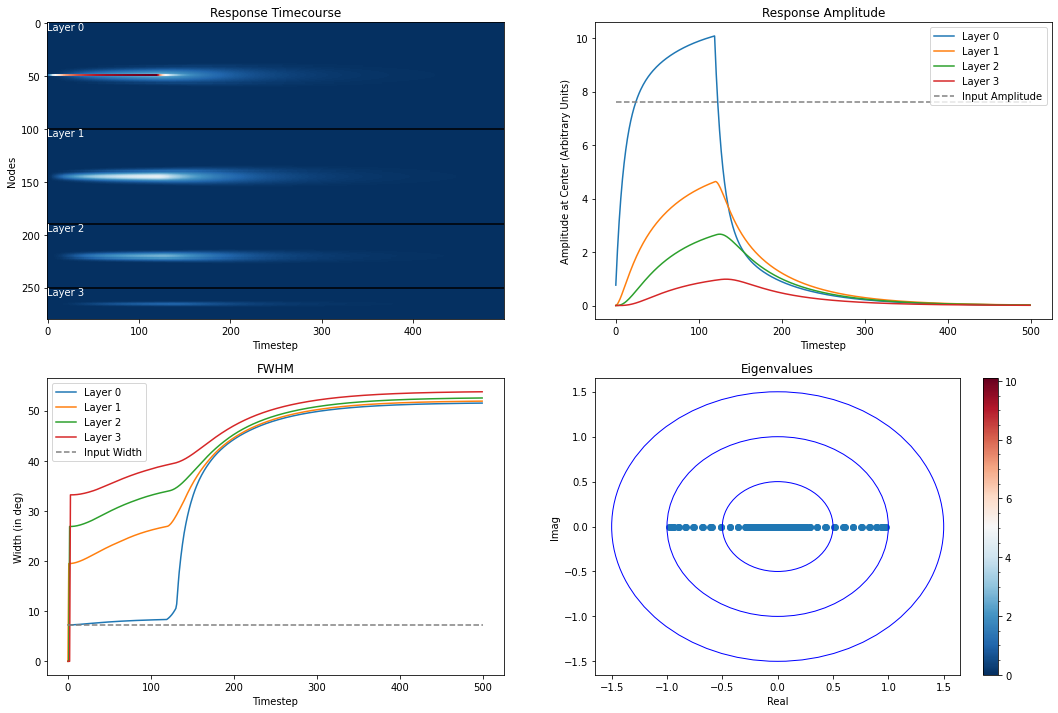

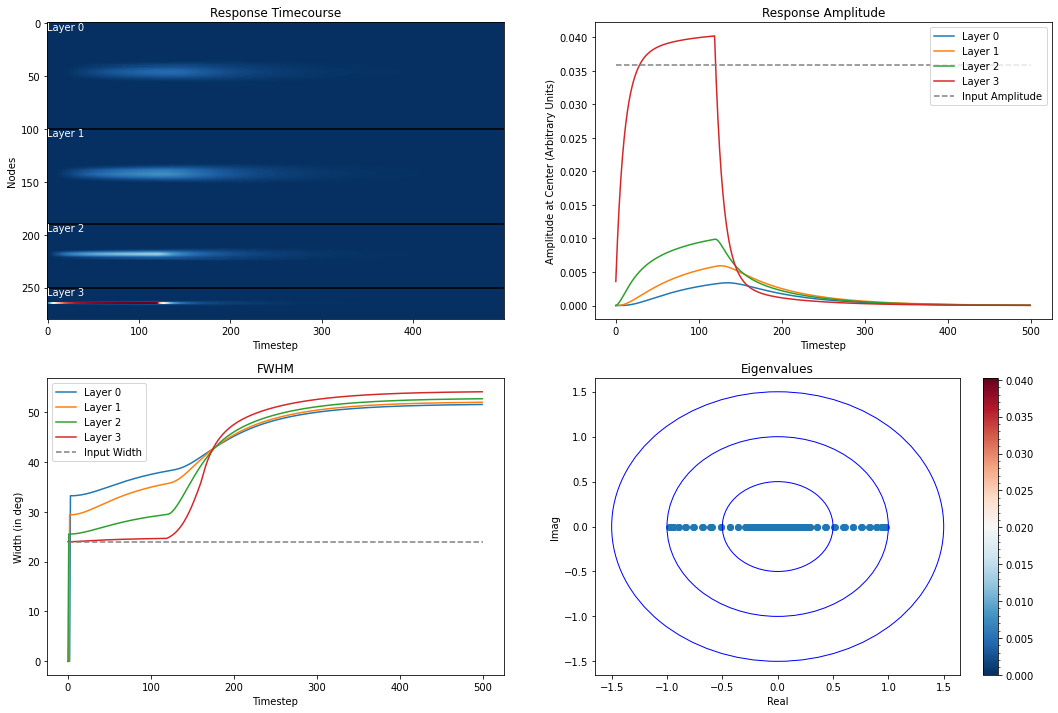

In [165]:
layer_sizes = [100, 90, 60, 30]
kappas = [50, 50, 50]

n_timesteps = 500
x_pos = 180
stim_on = 120
k_input = 1000

model = DynaToy(layer_sizes)
# model.W_ff_0 = .11
# model.W_ff_1 = -0.03
# model.W_fb_0 = 0.03
# model.W_fb_1 = -0.03
model.W_ff_0 = .05     # Scales the FF weights - affects the next layer's amplitude
model.W_ff_1 = -.003       # Shifts the FF weights 
model.W_fb_0 = .05    # Scales the FB weights - affects the prev layer's amplitude
model.W_fb_1 = -.003        # Shifts the FB weights 

# Scale and Shift the Recurrence weights
model.W_r_0 = 0.05
model.W_r_1 = -0.3

recurrence = ''

model.W, W_L = model.init_weights(plot = True, kappas = kappas, return_matrices=True, recurrence = recurrence)

theta = np.linspace(0, 2*np.pi, layer_sizes[0])
h = stats.vonmises.pdf(theta, k_input, np.radians(x_pos), 1)
h = np.expand_dims(h, 1)

plt.show()
plt.plot(np.linspace(-180, 180, h.shape[0]), h)
plt.title("Input")
plt.show()

# Feedforward
timecourse = np.zeros([model.r.shape[0], n_timesteps])
H = np.zeros_like(timecourse)

for t in range(n_timesteps):
    x_in = np.zeros_like(model.r)
    if t < stim_on:
        x_in[model.in_idx] = h
        model.r = model.euler(h = x_in)
    else:
        model.r = model.euler(h = x_in)

    timecourse[:, t] = model.r.squeeze()
    H[:, t] = x_in.squeeze()
    
model.plot(timecourse, h)

# Feedback
model.reset()

theta = np.linspace(0, 2*np.pi, layer_sizes[-1])
h = stats.vonmises.pdf(theta, k_input, np.radians(x_pos), 1)
h = np.expand_dims(h, 1)

timecourse = np.zeros([model.r.shape[0], n_timesteps])
H = np.zeros_like(timecourse)

for t in range(n_timesteps):
    x_in = np.zeros_like(model.r)
    if t < stim_on:
        x_in[model.out_idx] = h
        model.r = model.euler(h = x_in)
    else:
        model.r = model.euler(h = x_in)

    timecourse[:, t] = model.r.squeeze()
    H[:, t] = x_in.squeeze()
    
model.plot(timecourse, h)




In [166]:
np.linalg.eigvals(model.W).max()

(0.9825279602507901+0j)

Could attention modulation work here by scaling the recurrent weights in each layer?

Or, Recurrent weights are exist in a state, such that, when inhibited, they sharpen the representation in a layer

Or